In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import eda.edautils as eda

## 1. Carregando os dados
Para fins de comparação do modelo, os dados originais (sem o processamento relativo a EDA), também são carregado.

In [96]:
wine_data = pd.read_csv('data/winequality_processed.csv')

In [97]:
wine_data_original = pd.read_csv('data/winequality.csv', sep=';')
eda.to_categorical(wine_data_original, 'type')
errors = wine_data_original['alcohol'][pd.to_numeric(wine_data_original['alcohol'], errors='coerce').isnull()]
wine_data_original.drop(errors.index, inplace=True)

## 2. Separar os dados de treino e do label

In [98]:
def divide_training_data(data):
    data['quality'] = data['quality'].astype(int)
    X_train = data.drop(labels=['quality'], axis=1)
    label_train = data['quality']
    return X_train, label_train

## 3. Validação cruzada (k-fold)
Utilizar validação cruzada (k-fold) para estimar a qualidade do modelo. Escolheu-se 10 para o valor de k, o número iterações do processo, onde em cada iteração uma parte do conjunto de dados é utilizada para ser o conjunto de teste. Os conjuntos de dados de teste utilizados em cada iteração são mutuamente exclusivos.

In [99]:
kfold = StratifiedKFold(5)

## 4. Testando vários algoritmos de classificação
Visto que o conjunto de dados em questão é pequeno e também que a biblioteca sklearn disponibiliza várias funções para avaliação de modelos com validação cruzada, selecionou-se os principais algoritmos disponíveis na mesma (Floresta Aleatória, SVM, Árvore de Decisão, MLP(Rede Neural), Vizinho mais Próximo e Regressão Logística) para serem testados na tarefa de aproximação dentro dos dados processados anteriormente na análise exploratória.

Ao serem executados com os parâmetros padrão, SVM e Floresta Aleatória apresentaram a maior acurácia na classificação dos dados, 0.804 e 0.807, respectivamente.

In [100]:
classifiers = []
classifiers.append(RandomForestClassifier())
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(MLPClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())


In [101]:
def check_model_accuracy(classifiers, X_train, label_train):
    results = []
    for classifier in classifiers :
        results.append(cross_val_score(classifier, X_train, y=label_train, scoring="accuracy", cv=kfold))

    results_mean = []
    results_std = []
    for result in results:
        results_mean.append(result.mean())
        results_std.append(result.std())

    return results, results_mean, results_std

In [102]:
X_train, label_train = divide_training_data(wine_data)

processed_results, processed_means, processed_std = check_model_accuracy(classifiers, X_train, label_train)
print(processed_means)

[0.8023942092779552, 0.8069461917492056, 0.7487827802884255, 0.8054343135346036, 0.7789613193311415, 0.7975059531506985]


## 5. Tunning dos parâmetros e Escolha do algoritmo 
Visto que dois algoritmos atingiram praticamente a mesma precisão e que todos algoritmos foram executados com parâmetros default, deve-se definir com mais rigor tais parâmetros para que se possa escolher um dos dois algoritmos para construir o modelo final. Para tanto, é possível definir um conjunto de possíveis parâmetros para serem testados. O final da execução retorna a melhor combinação de parâmetros.

In [103]:
k = 5
n_jobs=4

### 5.1 SVM

In [104]:
SVMC = SVC(probability=True)
param_grid = {'kernel':['rbf'], 'gamma':[0.001, 0.01, 0.1, 1], 'C':[1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid=param_grid, cv=k, scoring="accuracy", n_jobs=n_jobs)
gsSVMC.fit(X_train,label_train)
gsSVMC.best_score_

0.8098128477491148

### 5.2 Random Forest

In [105]:
RFC = RandomForestClassifier()

param_grid = {'n_estimators':[400], 'max_leaf_nodes':[100,250], 'min_samples_split':[5,8,10], 'max_features':['log2','sqrt'], 'max_depth':[10,16,20], 'min_samples_leaf':[2,5,10]} 
gridsRFC = GridSearchCV(RFC, param_grid=param_grid, cv=k, scoring="accuracy", n_jobs=n_jobs, verbose=1)
gridsRFC.fit(X_train, label_train)

print(gridsRFC.best_estimator_)
print(gridsRFC.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 10.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8150396223233856


## 6. Tunning dos parâmetros e Função Custo
Ao analisar a acurácia atingida pelos dois algoritmos com várias combinações de parâmetros, observou-se que o algoritmo de RadomForest atingiu o melhor resultado (0.8104 x ). Portanto, tal algoritmo foi escolhido para construir o modelo de dados de qualidade do vinho. Para tanto, o algoritmo deve ser instanciado utilizando a melhor combinação de parâmetros devem alcançada no passo anterior:

In [106]:
best_params = {'n_estimators':[400], 'max_leaf_nodes':[250], 'min_samples_split':[8], 'max_features':['log2','sqrt'], 'max_depth':[16], 'min_samples_leaf':[5]} 
print(gridsRFC.best_estimator_)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


É importante observar a função custo do algoritmo escolhido (RandomForest), o qual consiste de um "ensemble" (combinação) da classificação de várias árvores de decisão. As iterações realizadas por uma árvore de decisão para aprender um modelo consistem de sucessivos splits (partições) no conjunto de datos. Para avaliar tais splits, o algoritmo utiliza o índice Gini como função custo, o qual mede a impureza de um subconjunto dos dados calculando a homenidade dos valores do label (i.e.: o quão heterogêneo são os valores do label em tal subconjunto).

## 7. Curva de aprendizagem 
A curva de aprendizagem (learning curve) abaixo mostra que, apesar da variação dos dados de treino em relação aos de teste ser relativamente alta, não se pode afirmar que existe uma tendência de over fitting, pois os scores do conjunto de teste seguem uma tendência com o número de exemplos.

In [134]:
def plot_learning_curve(estimator, title, X, y, train_sizes=[1, 4744], cv=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training samples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross validation accuracy")
    plt.legend(loc="best")
    return plt


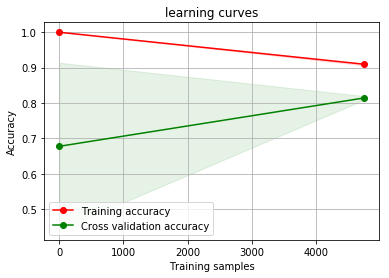

In [135]:
g = plot_learning_curve(gridsRFC.best_estimator_, "learning curves", X_train, label_train, cv=kfold)

## 8. Comparação com o modelo sem EDA
Como último teste, pode-se comparar o valor das precisões atingidas entre o modelo final depois de tratar os dados e  um modelo com os dados originais fornecidos (sem nenhum processamento). Nota-se o modelo final é significativamente superior ao modelo que utiliza os dados originais.

In [108]:
original_X_train, original_label_train = divide_training_data(wine_data_original)
original_results, original_means, original_std = check_model_accuracy(classifiers, original_X_train, original_label_train)

print(original_means)
print(original_std)

[0.4695408894050562, 0.4370378219285998, 0.3981754044718019, 0.46209805127101244, 0.39738076522072535, 0.4995894911588966]
[0.04119281477433396, 0.02470528858689971, 0.013381445818249472, 0.05636426639103975, 0.02014955154440581, 0.054995228238808314]
